In [8]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
import pickle
import preprocess_library as pre
from scipy import signal
import pywt
import pandas as pd
from scipy import stats
from scipy.integrate import simpson
import mne
from mne.datasets.sleep_physionet.age import fetch_data
import mne
import os
import xml.etree.ElementTree as ET
import numpy as np

In [9]:
channels = [
    'EEG(sec)',
    'ECG',
    'EMG',
    'EOG(L)',
    'EOG(R)',
    'EEG',
]

FS = 125
EPOCH_SEC_LENGTH = 30
SAMPLES_PER_EPOCH = FS * EPOCH_SEC_LENGTH

patient_data, patient_xml = pre.load_patient_data(1, 'Input',channels, 'Output')
print(patient_data)




Loading raw and XML data from cache files in Output...
Successfully loaded data from cache.
Cache contains data for 1 patients.
[{'EEG(sec)': array([-4.41176471e-06,  5.39215686e-06,  2.45098039e-06, ...,
        1.61764706e-05, -1.42156863e-05, -1.23039216e-04]), 'ECG': array([3.43137255e-05, 3.43137255e-05, 3.43137255e-05, ...,
       5.39215686e-05, 6.37254902e-05, 1.47058824e-05]), 'EMG': array([ 1.26225490e-05,  3.79901961e-06, -3.55392157e-06, ...,
        1.45833333e-05,  3.12500000e-05,  1.40931373e-05]), 'EOG(L)': array([2.89215686e-05, 4.14851766e-05, 2.79971535e-05, ...,
       5.45829844e-05, 6.98578211e-06, 4.51355172e-06]), 'EOG(R)': array([ 1.22549020e-05,  2.16168453e-05,  1.02921972e-05, ...,
        6.36996011e-05,  9.81517488e-06, -3.28092843e-06]), 'EEG': array([-2.45098039e-06,  1.47058824e-06, -9.31372549e-06, ...,
        2.99019608e-05,  1.25000000e-04,  6.91176471e-05]), 'ABDO RES': array([0.30980392, 0.32522044, 0.3361858 , ..., 0.23968197, 0.2666027 ,
       

In [10]:
# Remove the first and last 30 minutes of data
SECONDS_TO_REMOVE = 30 * 60 # 30 minutes in seconds
SAMPLE_TO_REMOVE = SECONDS_TO_REMOVE * FS

raw_data = {}
for channel_name in channels:
    raw_data[channel_name] = patient_data[0][channel_name][SAMPLE_TO_REMOVE:-SAMPLE_TO_REMOVE]
patient_stage = patient_xml[0]['stages'][SECONDS_TO_REMOVE:-SECONDS_TO_REMOVE]

In [21]:
filtered_data = {}

for channel_name in channels:
    tmp = pre.butter_bandpass(raw_data[channel_name], 0.5, 60, FS, order=4)
    data_filtered = pre.notch_filter(tmp, FS, 60, 60)
    filtered_data[channel_name] = data_filtered
    

(-134.0, -93.0)

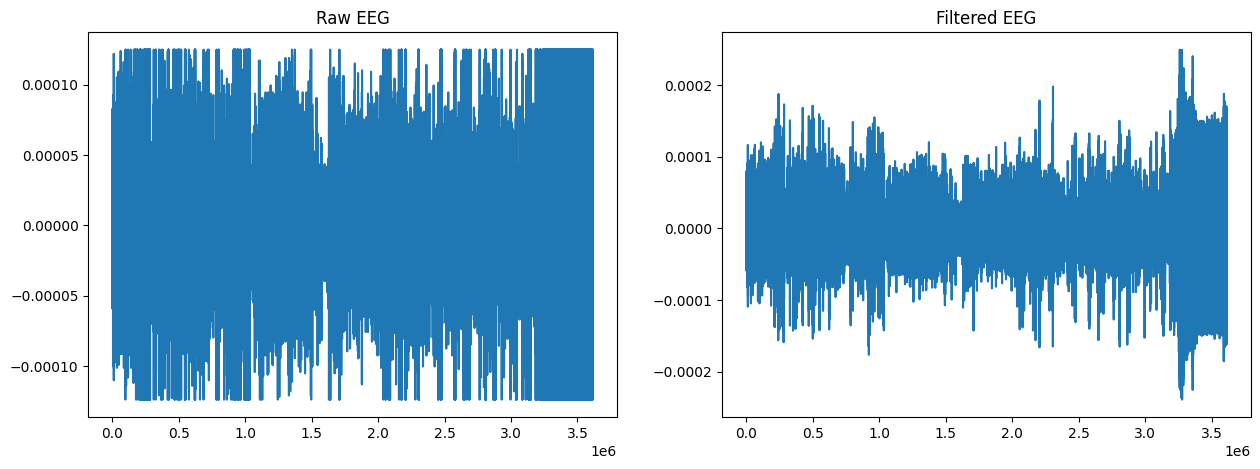

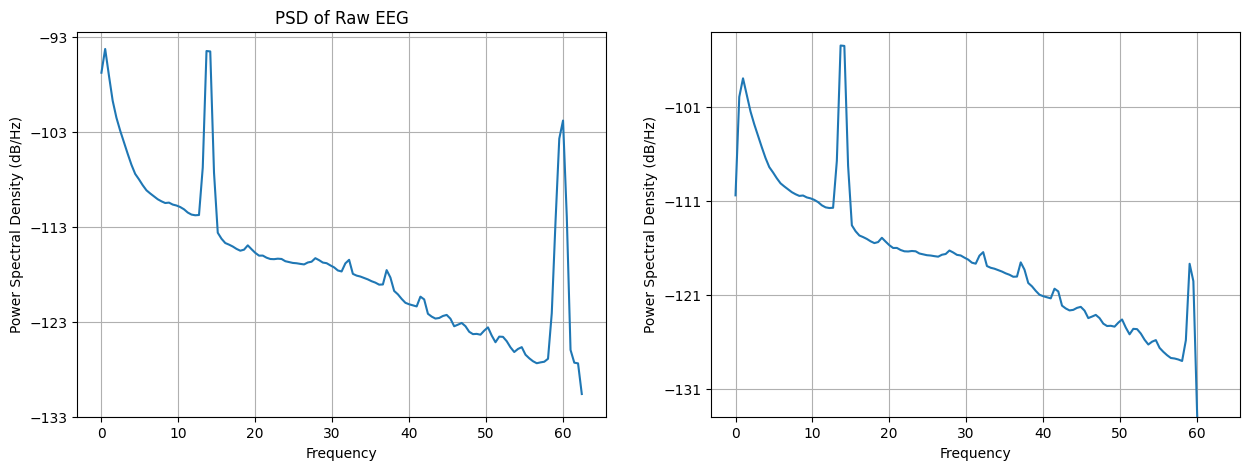

In [22]:
# Plot the raw and filered data of channel EEG(sec)
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(raw_data['EEG'])
plt.title('Raw EEG')
plt.subplot(1, 2, 2)
plt.plot(filtered_data['EEG'])
plt.title('Filtered EEG')

# Plot the PSD of the raw and filtered data of channel EEG
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.psd(raw_data['EEG'], Fs=FS)
plt.title('PSD of Raw EEG')
plt.subplot(1, 2, 2)
plt.psd(filtered_data['EEG'], Fs=FS)
plt.ylim(-134, -93)

Text(0.5, 1.0, 'Normalized EEG')

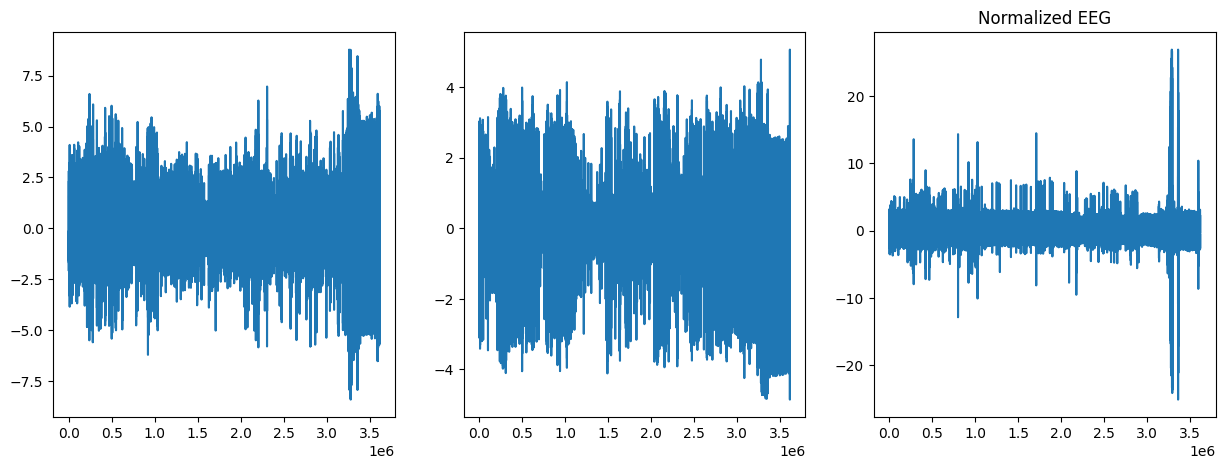

In [25]:
# Normalize the data
normalized_data = {}
# Ensure scipy.stats is imported, e.g., from scipy import stats
for channel_name in channels:
    # Apply Z-score normalization using scipy.stats.zscore
    channel_normalized = stats.zscore(filtered_data[channel_name])
    # Store the normalized data in the dictionary
    normalized_data[channel_name] = channel_normalized

# Plot the normalized data for a specific channel, e.g., 'EEG'
plt.figure(figsize=(15, 5))
# Select the specific channel to plot, for example 'EEG'
# If you want to plot a different channel, change 'EEG' accordingly
plt.subplot(1, 3, 1)
plt.plot(normalized_data['EEG'])
plt.subplot(1, 3, 2)
plt.plot(normalized_data['EMG'])
plt.subplot(1, 3, 3)
plt.plot(normalized_data['ECG'])
plt.title('Normalized EEG')


In [7]:
patient_epoch = {} # Initialize as a dictionary

# Process each channel
for channel_idx, channel_name in channels.items():
    # Get the channel data for this patient
    channel_data = filtered_data[channel_name]

    # Create a list to store all epochs for this channel
    channel_epochs = []

    # Split the data into epochs
    for epoch_idx in range(NB_EPOCHS):
        start_idx = epoch_idx * SAMPLES_PER_EPOCH
        end_idx = start_idx + SAMPLES_PER_EPOCH
        epoch_data = channel_data[start_idx:end_idx]
        channel_epochs.append(epoch_data)

    # Store all epochs for this channel in the patient's dictionary
    patient_epoch[channel_name] = channel_epochs

    print(f"  - Channel {channel_name}: Created {len(channel_epochs)} epochs of length {SAMPLES_PER_EPOCH}")

  - Channel EEG(sec): Created 964 epochs of length 3750
  - Channel ECG: Created 964 epochs of length 3750
  - Channel EMG: Created 964 epochs of length 3750
  - Channel EOG(L): Created 964 epochs of length 3750
  - Channel EOG(R): Created 964 epochs of length 3750
  - Channel EEG: Created 964 epochs of length 3750
  - Channel ABDO RES: Created 964 epochs of length 3750
